In [2]:
from langgraph.prebuilt import ToolNode, tools_condition
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from dotenv import load_dotenv
from langchain_chroma import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from tavily import TavilyClient
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated
from langchain_core.output_parsers import PydanticOutputParser
import os
from langchain_text_splitters import CharacterTextSplitter
import ast
from langchain_community.vectorstores import FAISS


An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


c:\Users\tapis\miniconda3\envs\py39\lib\site-packages\google\api_core\_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.23) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)


In [3]:
load_dotenv()

True

In [4]:
google_api_key = os.environ['GEMINI_API_KEY']
tavily_api_key = os.environ["TAVILY_API_KEY"]

In [5]:
FAISS_PATH = r"G:\My Drive\GEN_AI_IBM_competition\demo_embeddings"

embeddings = GoogleGenerativeAIEmbeddings(
    model="models/text-embedding-004",
    google_api_key=google_api_key
)
new_vector_store = FAISS.load_local(
    FAISS_PATH, 
    embeddings, 
    allow_dangerous_deserialization=True
)

print("Loaded existing vector store from disk.")

retriever = new_vector_store.as_retriever()

Loaded existing vector store from disk.


In [6]:
client = TavilyClient(api_key=tavily_api_key) 

In [7]:
@tool
def search_knowledge_base(query: str) -> str:

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks about MSME and GST.
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [8]:
@tool
def web_search(query: str) -> str:
    """
    This tool answer the query about MSME, GST regulations only in the context of india.
    Args:
        query (str): Search query.
    
    Returns:
        str: Search context or error message.
    """
    response = client.get_search_context(
        query=query,
        search_depth="basic",
        max_tokens=2500
    )
    summary = ""
    for r in response["results"]:
        summary += r["title"] + ": " + r["content"] + "\n"
    return summary

In [9]:
tools = [search_knowledge_base, web_search]

In [10]:
llm = HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-V3", # Make sure this Model ID is correct on HF*
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
    huggingfacehub_api_token=os.environ['HF_TOKEN']
)

model = ChatHuggingFace(llm=llm)

c:\Users\tapis\miniconda3\envs\py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
model_with_tool = model.bind_tools(tools)

In [12]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [13]:
def chat_node(state: ChatState):
    """
    You are a specialized AI assistant for the Department of MSME and GST Council of India. Your sole purpose is to assist users with queries related to Micro, Small, and Medium Enterprises (MSME) and Goods and Services Tax (GST) in India.

### 1. SCOPE OF OPERATIONS
- You must ONLY answer questions directly related to MSME schemes, regulations, registration (Udyam), GST filing, tax slabs, compliance, and government notifications in India.
- If a user asks about topics outside this scope (e.g., general news, entertainment, coding, non-Indian tax laws), strictly REFUSE to answer. State politely that you can only assist with MSME and GST India queries.

### 2. DATA SOURCE PRIORITY
You have access to two information sources: **Provided Context (RAG)** and a **Web Search Tool**. You must follow this strict hierarchy:

**STEP 1: Check Provided Context (RAG)**
- First, analyze the context provided in the user's message or history.
- If the answer is present in the context, generate the response *solely* from that information.
- Do NOT use the Web Search Tool if the Provided Context is sufficient.

**STEP 2: Fallback to Web Search**
- If (and ONLY if) the answer is **not** in the Provided Context, you must evaluate the query:
  - Is the query strictly related to MSME or GST in India?
  - If **YES**: Use the `web_search` tool to find the specific scheme, notification, or regulation.
  - If **NO**: Do not use the tool. Refuse the query as "out of scope."

### 3. RESPONSE GUIDELINES
- **Accuracy:** For GST rates or legal sections, be precise. If the web search is ambiguous, state that you cannot verify the information.
- **Citations:** When using the Web Search tool, mention the source (e.g., "According to the latest CBIC notification...").
- **Tone:** Professional, bureaucratic yet helpful, and strictly objective.

### EXAMPLE BEHAVIORS
- **User:** "How do I register for Udyam?" 
  -> *Action:* Check RAG. If missing, use Web Search for "Udyam registration process India".
- **User:** "What is the GST rate for gold?" 
  -> *Action:* Check RAG. If missing, use Web Search for "current GST rate gold India".
- **User:** "Who won the cricket match yesterday?"
  -> *Action:* IGNORE tools. Reply: "I can only assist with MSME and GST related queries."
    """
    messages = state['messages']
    response = model_with_tool.invoke(messages)
    return {"messages": [response]}
tool_node = ToolNode(tools)

In [14]:
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

In [15]:
graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")    

In [16]:
chatbot = graph.compile()

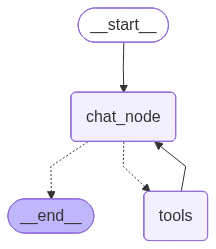

In [17]:
chatbot

In [18]:
out = chatbot.invoke({"messages": [HumanMessage(content="Can you please tell me punjab jump in gst collection?")]})
print(out["messages"][-1].content)

It seems there was an issue retrieving the information about Punjab's GST collection jump. Let me try an alternative approach to find the relevant details for you.


In [30]:
# def search_knowledge_base(query: str) -> dict:

#     """
#     Retrieve relevant information from the pdf document.
#     Use this tool when the user asks about MSME and GST.
#     that might be answered from the stored documents.
#     """
#     result = retriever.invoke(query)
#     print(result)
#     context = [doc.page_content for doc in result]
#     metadata = [doc.metadata for doc in result]

#     return {
#         'query': query,
#         'context': context,
#         'metadata': metadata
#     }

In [ ]:
# import os
# # Imports
# from langchain_community.document_loaders import PyPDFDirectoryLoader
# from langchain_text_splitters import RecursiveCharacterTextSplitter
# from langchain_community.vectorstores import FAISS
# from langchain_google_genai import GoogleGenerativeAIEmbeddings # Ensure this is imported

# # --- FIX 1: Use Raw String (r) and Check Folder Name ---
# # Check spelling: Is it 'STUFdf' or 'STUFF'?
# FOLDER_PATH = r"G:\My Drive\GEN_AI_IBM_competition\OTHER_STUFF" 

# print(f"Checking path: {FOLDER_PATH}")
# if not os.path.exists(FOLDER_PATH):
#     raise FileNotFoundError(f"❌ Folder nahi mila! Path check karo: {FOLDER_PATH}")

# # 1. Load Docs
# loader = PyPDFDirectoryLoader(FOLDER_PATH)
# docs = loader.load()

# # --- CRITICAL CHECK ---
# if len(docs) == 0:
#     raise ValueError("❌ Error: 0 documents loaded. Folder khali hai ya path galat hai.")

# print(f"✅ Loaded {len(docs)} documents.")

# # 2. Split Docs
# splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
# chunks = splitter.split_documents(docs)

# if len(chunks) == 0:
#     raise ValueError("❌ Error: Chunks nahi bane. Text content check karo.")

# print(f"✅ Created {len(chunks)} chunks.")

# # 3. Embeddings & Vector Store
# embeddings = GoogleGenerativeAIEmbeddings(
#     model="models/text-embedding-004",
#     google_api_key=google_api_key 
# )

# try:
#     print("Generating embeddings and FAISS index...")
#     vector_store = FAISS.from_documents(chunks, embeddings)
#     print("✅ FAISS Index created successfully!")
# except Exception as e:
#     print(f"❌ Error creating FAISS index: {e}")
# retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

# def rag_tool(query):
#     """
#     Retrieve relevant information from the pdf document.
#     """
#     print(f"Searching for: {query}")
#     result = retriever.invoke(query)

#     context = [doc.page_content for doc in result]
#     metadata = [doc.metadata for doc in result]

#     return {
#         'query': query,
#         'context': context,
#         'metadata': metadata
#     }

Checking path: G:\My Drive\GEN_AI_IBM_competition\OTHER_STUFF
✅ Loaded 2374 documents.
✅ Created 6964 chunks.
Generating embeddings and FAISS index...
✅ FAISS Index created successfully!
